# **Aplicación Cuantización de Modelo MobileNetV3-Large**
El presente notebook fué desarrollado con el objetivo de aplicar la técnica de Cuantización de modelos de aprendizaje profundo sobre la arquitectura ´MobileNetV3-Large´, previamente entrenada mediante aprendizaje supervisado para la detección y clasificación de enfermedades foliares en cultivos de maíz —específicamente roya común, mancha gris y tizón foliar—, así como para la identificación de hojas sanas.

El propósito principal de este script es optimizar el modelo para su despliegue en entornos de borde (edge devices), mediante la aplicación progresiva de  cuantización (quantization), evaluando en cada etapa las métricas de rendimiento con el fin de reducir el tamaño y el consumo computacional del modelo sin comprometer significativamente su confiabilidad ni precisión.


In [ ]:
# ==========================================
# IMPORTE DE LIBRERIAS
# ==========================================
import os, time, json, statistics
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from pathlib import Path
from google.colab import drive
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report

# conectar con drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Configuración del Entorno**
En esta sección se establece la configuración inicial del entorno de ejecución y los parámetros globales requeridos para aplicar la técnica de cuantización sobre el modelo `MobileNetV3-Large`.

Se definen las siguientes variables  como parte de la configuración:


*   **MODEL_PATH:** ruta del modelo base (Keras) que será optimizado.
*   **PRUNED_PATH:** ruta de salida del modelo podado
*   **PRUNED_FINETUNED_PATH:** ruta de salida del modelo podado + fine-tuning.
*   **DATA_DIR:** carpeta con los datos usados.
*   **OUTPUT_DIR:** carpeta de artefactos de salida



Se define un diccionario `CONFIG` que contiene las rutas y parámetros clave del proceso:


*   **IMG_SIZE:**
      tamaño de las imágenes de entrada al modelo, definido como (224 × 224) píxeles, compatible con la arquitectura MobileNetV3.
*   **BATCH_SIZE:**
      tamaño del lote utilizado durante las evaluaciones o conversiones, en este caso, 64 imágenes por lote.
*   **REPRESENTATIVE_SAMPLES:**
      número de muestras para la calibración INT8 del representative dataset;.
*   **INFERENCE_RUNS:**
      repeticiones usadas para medir latencia promedio de inferencia.
*   **WARMUP_RUNS:**
      corridas iniciales para estabilizar cachés/JIT antes de medir.

      

Además, se realiza una verificación automática de la disponibilidad de GPU utilizando tf.config.list_physical_devices('GPU'). Si una GPU está disponible, se habilita el crecimiento dinámico de memoria (set_memory_growth), lo que permite un uso más eficiente de los recursos durante las operaciones de TensorFlow.


In [ ]:
#=============================
#  1. CONFIGURACIÓN
#=============================

# Ruta al modelo .keras entrenado
MODEL_PATH = "/content/drive/MyDrive/modelo_final_mejorado.keras"
PRUNED_PATH = "/content/drive/MyDrive/modelo_pruneado.keras"
PRUNED_FINETUNED_PATH = "/content/drive/MyDrive/modelo_pruneado_finetuneado.keras"
DATA_DIR = "/content/drive/MyDrive/data"
OUTPUT_DIR = "/content/converted_models"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Config experiment
CONFIG = {
    "IMG_SIZE": (224,224),
    "BATCH_SIZE": 64,
    "REPRESENTATIVE_SAMPLES": 100,   # para calibración int8
    "INFERENCE_RUNS": 200,           # repeticiones para medir latencia
    "WARMUP_RUNS": 10
}

## **Carga de Modelos y Datos**

En esta sección se realiza la importación del conjunto de datos y la carga del modelo base que servirá como punto de partida para la aplicación de las técnica de cualtización.

Primero, se establece la conexión con Google Drive mediante la instrucción drive.mount('/content/drive'), lo que permite acceder a los archivos almacenados en la nube desde el entorno de ejecución de Google Colab.

A continuación, se carga el conjunto de datos de prueba utilizando la función `image_dataset_from_directory`, la cual permite generar un dataset de TensorFlow directamente desde un directorio estructurado en carpetas por clase.
Tambien se cargan los modelos previamnete entrenados.

In [ ]:
# ==========================================
# 2. CARGAR MODELOS
# ==========================================

# Carga modelo original
model = tf.keras.models.load_model(MODEL_PATH)

print("\n" + "="*30)
print("Modelo Original")
print("="*30 + "\n")

model.summary()
print("Modelo cargado correctamente desde:", MODEL_PATH)

# Carga modelo pruneado
pruned_model = tf.keras.models.load_model(PRUNED_PATH)

print("\n" + "="*30)
print("Modelo Pruneado")
print("="*30 + "\n")

pruned_model.summary()
print("Modelo cargado correctamente desde:", PRUNED_PATH, "\n")

# Carga modelo pruneado & finetuneado
pruned_finetuned_model = tf.keras.models.load_model(PRUNED_FINETUNED_PATH)

print("\n" + "="*30)
print("Modelo Pruneado & Finetuneado")
print("="*30 + "\n")

pruned_finetuned_model.summary()
print("Modelo cargado correctamente desde:", PRUNED_FINETUNED_PATH, "\n")

# Crear test dataset (sin shuffle) — usa tu carpeta test o subset
print("\n" + "="*30)
print("Dataset Test")
print("="*30 + "\n")

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(DATA_DIR, "test"),
    image_size=CONFIG["IMG_SIZE"],
    batch_size=CONFIG["BATCH_SIZE"],
    shuffle=False
)

class_names = test_ds.class_names
num_classes = len(class_names)
print("Classes:", class_names)



Modelo Original



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       492,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,499,662 (40.05 MB)

 Trainable params: 3,437,924 (13.11 MB)

 Non-trainable params: 185,888 (726.12 KB)

 Optimizer params: 6,875,850 (26.23 MB)

Modelo cargado correctamente desde: /content/drive/MyDrive/modelo_final_mejorado.keras

Modelo Pruneado



/usr/local/lib/python3.12/dist-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'adam', because it has 176 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       492,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,499,662 (40.05 MB)

 Trainable params: 3,437,924 (13.11 MB)

 Non-trainable params: 185,888 (726.12 KB)

 Optimizer params: 6,875,850 (26.23 MB)

Modelo cargado correctamente desde: /content/drive/MyDrive/modelo_pruneado.keras 


Modelo Pruneado & Finetuneado



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 960)            │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       492,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,499,662 (40.05 MB)

 Trainable params: 3,437,924 (13.11 MB)

 Non-trainable params: 185,888 (726.12 KB)

 Optimizer params: 6,875,850 (26.23 MB)

Modelo cargado correctamente desde: /content/drive/MyDrive/modelo_pruneado_finetuneado.keras 


Dataset Test

Found 1488 files belonging to 4 classes.
Classes: ['Blight', 'Common_Rust', 'Gray_Leaf_Spot', 'Healthy']


## **Cuantización de los modelos**

La función `convert_to_tflite_drq` convierte un modelo Keras a **TensorFlow Lite** aplicando **Dynamic-Range Quantization (DRQ)**: activa `Optimize.DEFAULT` en el convertidor, **sin representative dataset**, por lo que deja **entradas/salidas en `float32`** mientras **cuantiza los pesos a 8 bits**, reduciendo tamaño y, usualmente, acelerando en CPU (útil cuando no se pueden usar kernels INT8 o XNNPACK falla). Tras la conversión (`conv.convert()`), asegura la carpeta de destino, guarda los bytes TFLite en `out_path`, imprime la ruta y la retorna. Los argumentos `has_rescale_in_model` y `rep_normalize` se aceptan para posibles extensiones (p. ej., manejar normalizaciones o rutas de cuantización alternativas), pero **no se usan** en esta implementación.


In [ ]:
def convert_to_tflite_drq(model, out_path, has_rescale_in_model: bool, rep_normalize: bool = False):
    """
    DRQ = Dynamic-Range Quantization.
    - Pesa menos y suele acelerar CPU.
    - No necesita representative_dataset ni kernels INT8 en runtime.
    - Recomendado en este entorno donde XNNPACK crashea.
    """
    conv = tf.lite.TFLiteConverter.from_keras_model(model)
    conv.optimizations = [tf.lite.Optimize.DEFAULT]
    # Sin representative_dataset (clave de DRQ)
    # Entrada/salida quedan float32, interior de pesos cuantizado a 8 bits.
    tflite_bytes = conv.convert()
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
    with open(out_path, "wb") as f:
        f.write(tflite_bytes)
    print("DRQ guardado en:", out_path)
    return out_path

In [ ]:

#Detecta si el modelo trae Rescaling(1/255) dentro
# modelo
has_rescale = any(isinstance(l, tf.keras.layers.Rescaling) for l in model.layers)
drq_path = "./tflite_out/model_drq.tflite"
convert_to_tflite_drq(model, drq_path, has_rescale)

#pruneado
has_rescale_pruned = any(isinstance(l, tf.keras.layers.Rescaling) for l in pruned_model.layers)
drq_path_pruned = "./tflite_out/model_pruned_drq.tflite"
convert_to_tflite_drq(pruned_model, drq_path_pruned, has_rescale_pruned)

#pruneado & finetuneado
has_rescale_pruned_finetuned = any(isinstance(l, tf.keras.layers.Rescaling) for l in pruned_finetuned_model.layers)
drq_path_pruned_finetuned = "./tflite_out/model_pruned_finetuned_drq.tflite"
convert_to_tflite_drq(pruned_finetuned_model, drq_path_pruned_finetuned, has_rescale_pruned_finetuned)


Saved artifact at '/tmp/tmpxxni23o2'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  139857522674000: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857522675920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857522676688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857522674960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857522674768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857522677072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857522678224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857522678032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857522677264: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139857522678800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1398575226778

'./tflite_out/model_pruned_finetuned_drq.tflite'

## **Evaluación, Revisión y Resultados**

A continuación  se evalúan los modelos **TFLite** desactivando **XNNPACK** para evitar fallos y usar solo *built-in kernels*. Primero, `load_interpreter_no_xnnpack` establece `TF_LITE_DISABLE_XNNPACK=1`, crea un `tf.lite.Interpreter` con el número de hilos indicado y llama `allocate_tensors()`. Luego, `evaluate_tflite_model` carga ese intérprete, obtiene metadatos de entrada/salida y recorre el *dataset* de prueba ejemplo por ejemplo: si la entrada es **int8**, aplica la cuantización manual con **escala** y **punto cero**; invoca el modelo midiendo la **latencia por ejemplo** con `time.perf_counter`; y si la salida es int8, **descuantiza** a `float32` para calcular probabilidades. Con los *logits* obtiene la clase predicha, acumula `y_true/y_pred`, y al final calcula **accuracy**, **precision**, **recall**, **F1 ponderado**, **matriz de confusión** y el **tamaño del archivo** TFLite (MB). Imprime *accuracy* y latencia promedio (ms/ejemplo), opcionalmente un `classification_report` por clase, y devuelve todas las métricas en un diccionario.

De igual forma se generan las gráficas donde se muestran las metricas obtenidas para cada modelo.


In [ ]:

def load_interpreter_no_xnnpack(tflite_path: str, num_threads: int = 2):
    os.environ["TF_LITE_DISABLE_XNNPACK"] = "1"
    itp = tf.lite.Interpreter(
        model_path=tflite_path,
        experimental_delegates=[],
        experimental_op_resolver_type=tf.lite.experimental.OpResolverType.BUILTIN,
        experimental_default_delegate_latest_features=False,
        num_threads=num_threads
    )
    itp.allocate_tensors()
    return itp

# Cargar e inferir con el modelo TFLite

def evaluate_tflite_model(tflite_path, test_ds, class_names=None, num_threads=2):
    itp = load_interpreter_no_xnnpack(tflite_path, num_threads=num_threads)
    in_d, out_d = itp.get_input_details()[0], itp.get_output_details()[0]
    in_idx, out_idx = in_d['index'], out_d['index']
    in_dtype, out_dtype = in_d['dtype'], out_d['dtype']
    in_q, out_q = in_d.get('quantization', (0.0, 0)), out_d.get('quantization', (0.0, 0))

    y_true, y_pred, n, t_sum = [], [], 0, 0.0
    for bx, by in test_ds:
        bx = bx.numpy()
        by = by.numpy()
        for i in range(bx.shape[0]):
            x = bx[i:i+1]
            if in_dtype == np.int8:
                s, zp = in_q
                x = np.clip(np.round(x / s + zp), -128, 127).astype(np.int8) if s else x.astype(np.int8)
            else:
                x = x.astype(in_dtype)
            itp.set_tensor(in_idx, x)
            t0 = time.perf_counter()
            itp.invoke()
            t1 = time.perf_counter()
            t_sum += (t1 - t0)
            n += 1

            logits = itp.get_tensor(out_idx)
            if out_dtype == np.int8:
                s, zp = out_q
                probs = logits.astype(np.float32) if s == 0 else (logits.astype(np.float32) - zp) * s
            else:
                probs = logits.astype(np.float32)

            y_pred.append(int(np.argmax(probs, axis=-1)[0]))
            y_true.append(int(by[i]))

    y_true, y_pred = np.array(y_true), np.array(y_pred)
    acc = float((y_true == y_pred).mean())
    ms = (t_sum / max(1, n)) * 1000.0  # Tiempo por ejemplo (ms)

    # Calcular métricas adicionales
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')

    print(f"Accuracy: {acc:.4f} | {ms:.2f} ms/ejemplo")
    if class_names is not None:
        print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

    cm = confusion_matrix(y_true, y_pred)
    sz = os.path.getsize(tflite_path) / (1024 * 1024)  # Tamaño en MB
    # Retornar un diccionario con las métricas
    return {
        'accuracy': acc,
        'time_per_example_ms': ms,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'model_size_mb': sz,
        'confusion_matrix': cm
    }


In [ ]:
# Evaluar los modelos
original_metrics = evaluate_tflite_model('./tflite_out/model_drq.tflite', test_ds)
pruned_metrics = evaluate_tflite_model('./tflite_out/model_pruned_drq.tflite', test_ds)
pruned_ft_metrics = evaluate_tflite_model('./tflite_out/model_pruned_finetuned_drq.tflite', test_ds)

/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Accuracy: 0.9173 | 15.24 ms/ejemplo


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Accuracy: 0.9220 | 18.12 ms/ejemplo


/usr/local/lib/python3.12/dist-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


Accuracy: 0.8871 | 17.13 ms/ejemplo


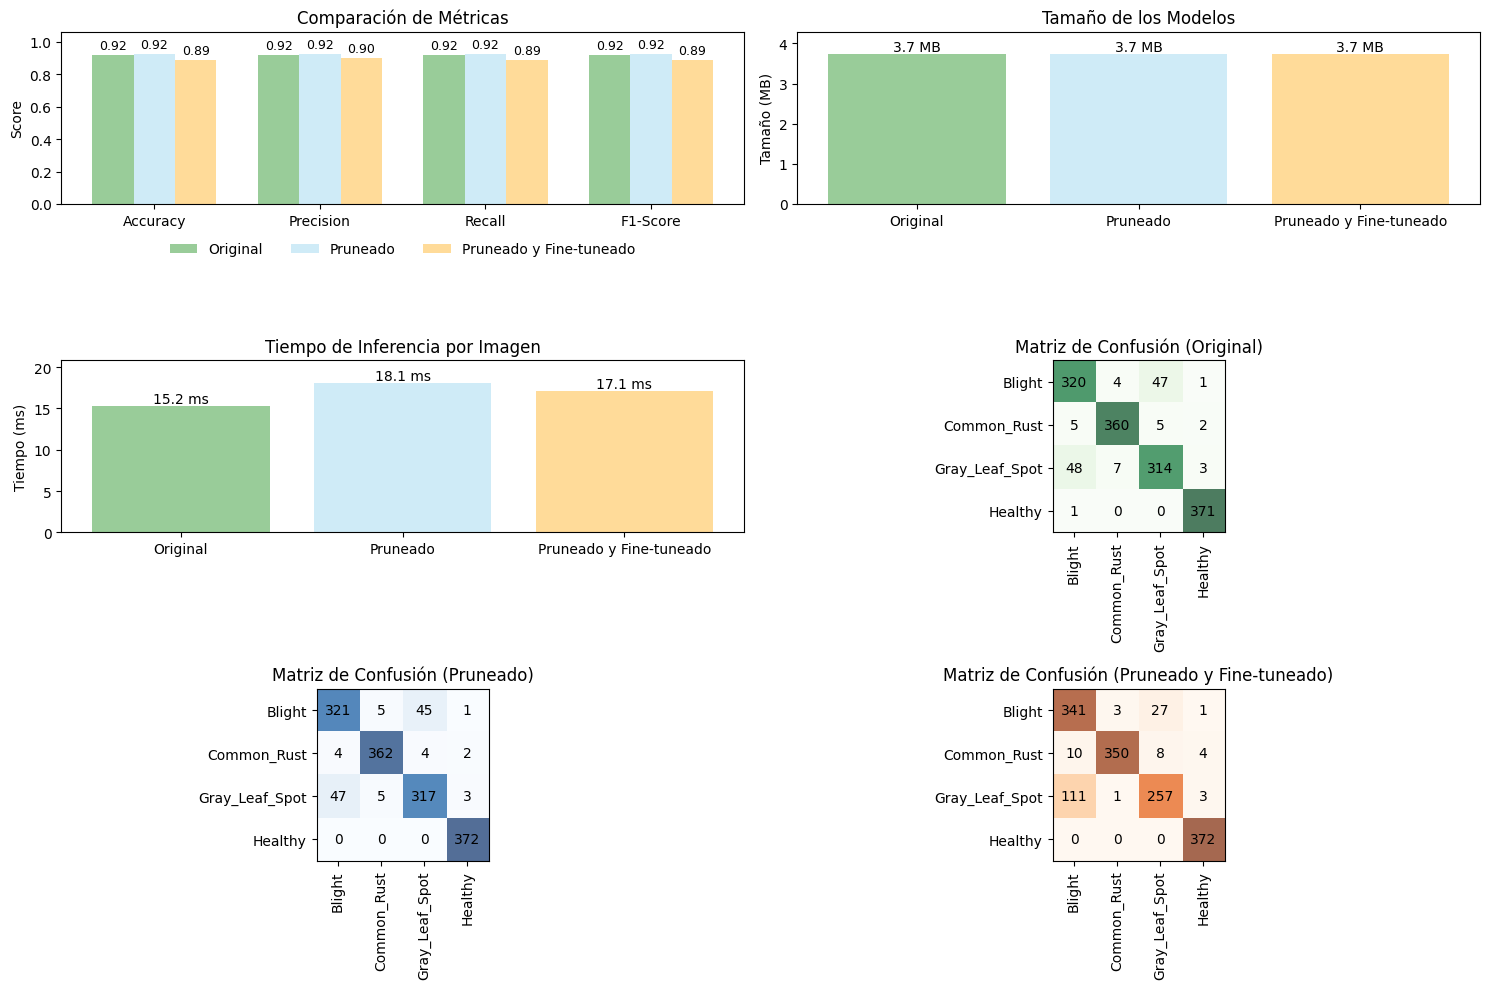

In [ ]:

fig, axes = plt.subplots(3, 2, figsize=(15, 10))

# Gráfica 1: Métricas de accuracy
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
metrics_original = [
    original_metrics['accuracy'],
    original_metrics['precision'],
    original_metrics['recall'],
    original_metrics['f1_score']
]
metrics_pruned = [
    pruned_metrics['accuracy'],
    pruned_metrics['precision'],
    pruned_metrics['recall'],
    pruned_metrics['f1_score']
]
metrics_pruned_ft = [
    pruned_ft_metrics['accuracy'],
    pruned_ft_metrics['precision'],
    pruned_ft_metrics['recall'],
    pruned_ft_metrics['f1_score']
]

x_pos = np.arange(len(metrics_names))
width = 0.25

bar1 = axes[0, 0].bar(x_pos - width, metrics_original, width, label='Original', alpha=0.4, color='green')
bar2 = axes[0, 0].bar(x_pos , metrics_pruned, width, label='Pruneado', alpha=0.4, color='skyblue')
bar3 = axes[0, 0].bar(x_pos + width, metrics_pruned_ft, width, label='Pruneado y Fine-tuneado', alpha=0.4, color='orange')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_title('Comparación de Métricas')
axes[0, 0].set_xticks(x_pos)
axes[0, 0].set_xticklabels(metrics_names, rotation=0)
axes[0, 0].legend()

max_size = max(max(metrics_original),max(metrics_pruned),max(metrics_pruned_ft))
axes[0, 0].set_ylim(0, max_size * 1.15)

# Añadir etiquetas sobre cada barra

for bars in [bar1, bar2, bar3]:
    for bar in bars:
        height = bar.get_height()
        axes[0, 0].text(
            bar.get_x() + bar.get_width() / 2,  # posición centrada en X
            height + 0.02,                      # ligeramente arriba de la barra
            f"{height:.2f}",                    # valor con dos decimales
            ha='center', va='bottom', fontsize=9, color='black'
        )

axes[0, 0].legend(
    loc='upper center',
    bbox_to_anchor=(0.5, -0.15),  # debajo de la gráfica
    ncol=3,
    frameon=False
)

# Gráfica 2: Tamaños de modelo

sizes_tflite = [original_metrics['model_size_mb'], pruned_metrics['model_size_mb'], pruned_ft_metrics['model_size_mb']]
labels = ['Original', 'Pruneado', 'Pruneado y Fine-tuneado']
colors = ['green', 'skyblue','orange']


axes[0, 1].bar(labels, sizes_tflite, color=colors, alpha=0.4)
axes[0, 1].set_ylabel('Tamaño (MB)')
axes[0, 1].set_title('Tamaño de los Modelos')

max_size = max(sizes_tflite)
axes[0, 1].set_ylim(0, max_size * 1.15)

# Añadir valores encima de las barras

for i, v in enumerate(sizes_tflite):
    axes[0, 1].text(i, v , f'{v:.1f} MB', ha='center', va='bottom')

# Gráfica 3: Tiempos de inferencia
times = [original_metrics['time_per_example_ms'], pruned_metrics['time_per_example_ms'], pruned_ft_metrics['time_per_example_ms']]
axes[1, 0].bar(['Original', 'Pruneado', 'Pruneado y Fine-tuneado'], times, color=['green', 'skyblue','orange'], alpha=0.4)
axes[1, 0].set_ylabel('Tiempo (ms)')
axes[1, 0].set_title('Tiempo de Inferencia por Imagen')

max_size = max(times)
axes[1, 0].set_ylim(0, max_size * 1.15)

# Añadir valores encima de las barras

for i, v in enumerate(times):
    axes[1, 0].text(i, v , f'{v:.1f} ms', ha='center', va='bottom')


# Gráfica 4: Matriz de confusión del modelo original
im = axes[1, 1].imshow(original_metrics['confusion_matrix'], cmap='Greens', alpha=0.7)
axes[1, 1].set_title('Matriz de Confusión (Original)')
axes[1, 1].set_xticks(range(len(class_names)))
axes[1, 1].set_yticks(range(len(class_names)))
axes[1, 1].set_xticklabels(class_names, rotation=90)
axes[1, 1].set_yticklabels(class_names)

# Añadir valores a la matriz
for i in range(len(class_names)):
    for j in range(len(class_names)):
        axes[1, 1].text(j, i, original_metrics['confusion_matrix'][i, j],
                       ha="center", va="center", color="black")

# Gráfica 5: Matriz de confusión del modelo pruneado
im = axes[2, 0].imshow(pruned_metrics['confusion_matrix'], cmap='Blues', alpha=0.7)
axes[2, 0].set_title('Matriz de Confusión (Pruneado)')
axes[2, 0].set_xticks(range(len(class_names)))
axes[2, 0].set_yticks(range(len(class_names)))
axes[2, 0].set_xticklabels(class_names, rotation=90)
axes[2, 0].set_yticklabels(class_names)

# Añadir valores a la matriz
for i in range(len(class_names)):
    for j in range(len(class_names)):
        axes[2, 0].text(j, i, pruned_metrics['confusion_matrix'][i, j],
                       ha="center", va="center", color="black")

# Gráfica 6: Matriz de confusión del modelo pruneado & Fine-tuneado
im = axes[2, 1].imshow(pruned_ft_metrics['confusion_matrix'], cmap='Oranges', alpha=0.7)
axes[2, 1].set_title('Matriz de Confusión (Pruneado y Fine-tuneado)')
axes[2, 1].set_xticks(range(len(class_names)))
axes[2, 1].set_yticks(range(len(class_names)))
axes[2, 1].set_xticklabels(class_names, rotation=90)
axes[2, 1].set_yticklabels(class_names)

# Añadir valores a la matriz
for i in range(len(class_names)):
    for j in range(len(class_names)):
        axes[2, 1].text(j, i, pruned_ft_metrics['confusion_matrix'][i, j],
                       ha="center", va="center", color="black")


plt.tight_layout()
plt.show()
